# Analysis of historic Irish weather

## Author: Joanna Mnich

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

In [124]:
def clean_station(file_path, output_path):
    """
    Clean a Met Éireann station CSV and save year, month, wdsp (mean wind speed).
    
    Args:
        file_path (str): path to raw CSV
        output_path (str): path to save cleaned CSV
    """

# Detect first row with actual numeric data (starts with a year)
    data_row = None
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            # skip empty lines, look for line starting with a digit (year)
            if line.strip() and line.strip()[0].isdigit():
                data_row = i
                break

    if data_row is None:
        print(f"No data found in {file_path}")
        return

# Read CSV from detected data row
    df = pd.read_csv(
        file_path,
        skiprows=data_row,
        header=None,
        na_values=["---", "NaN"],
        on_bad_lines="skip"
    )

# Assign proper column names (based on Met Éireann standard)
    col_names = [
        "year","month","meant","maxtp","mintp","mnmax",
        "mnmin","rain","gmin","wdsp","maxgt","sun"
    ][:df.shape[1]]  # adjust if file has fewer columns
    df.columns = col_names
    
# Keep only relevant columns
    df = df[["year", "month", "wdsp"]]

# Convert to numeric (coerce errors)
    for col in ["year", "month", "wdsp"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter years 2005–2025 and remove missing wdsp
    df = df.dropna(subset=["wdsp"])
    df = df[(df["year"] >= 2005) & (df["year"] <= 2025)]

# Save cleaned CSV
    df.to_csv(output_path, index=False)
    print(f"Saved {output_path} — rows: {len(df)}")


In [125]:
stations = {
    "Malin_Head": "Malin_Head.csv",
    "Roches_Point": "Roches_point.csv",
    "Sherkin_Island": "SherkinIsland.csv",
    "Valentia_Observatory": "Valentia_Observatory.csv",
    "Dublin_Airport": "Dublin_Airport.csv",
    "Phoenix_Park": "Phoenix_Park.csv",
    "Casement_Aerodrome": "Casement_Aerodrome.csv",
    "Belmullet": "Belmullet.csv",
    "Mullingar": "Mullingar.csv",
    "Claremorris": "Claremorris.csv"
}

for station, filename in stations.items():
    clean_station(
        file_path=f"data/raw/{filename}",
        output_path=f"data/processed/{station}_cleaned.csv"
    )


Saved data/processed/Malin_Head_cleaned.csv — rows: 250
Saved data/processed/Roches_Point_cleaned.csv — rows: 249
Saved data/processed/Sherkin_Island_cleaned.csv — rows: 249
Saved data/processed/Valentia_Observatory_cleaned.csv — rows: 249
Saved data/processed/Dublin_Airport_cleaned.csv — rows: 251
Saved data/processed/Phoenix_Park_cleaned.csv — rows: 2
Saved data/processed/Casement_Aerodrome_cleaned.csv — rows: 251
Saved data/processed/Belmullet_cleaned.csv — rows: 246
Saved data/processed/Mullingar_cleaned.csv — rows: 251
Saved data/processed/Claremorris_cleaned.csv — rows: 243


FileNotFoundError: [Errno 2] No such file or directory: 'plots/Malin_Head_monthly_wind_speed.png'

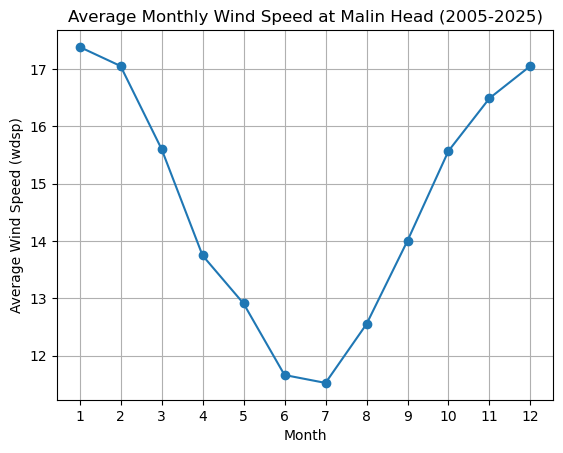

In [127]:
# Monhly average wind speed plot for each station
for station in stations.keys():
    df = pd.read_csv(f"data/processed/{station}_cleaned.csv")
    monthly_avg = df.groupby("month")["wdsp"].mean()

    plt.figure()
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
    plt.title(f"Average Monthly Wind Speed at {station.replace('_', ' ')} (2005-2025)")
    plt.xlabel("Month")
    plt.ylabel("Average Wind Speed (wdsp)")
    plt.xticks(range(1, 13))
    plt.grid()
    plt.savefig(f"plots/{station}_monthly_wind_speed.png")
    plt.close()


In [ ]:
import os
import glob

processed_folder = "data/processed"
files = glob.glob(os.path.join(processed_folder, "*_cleaned.csv"))

print("Files found:")
for f in files:
    print(f)


Files found:
data/processed\all_stations_cleaned.csv
data/processed\Belmullet_cleaned.csv
data/processed\Casement_Aerodrome_cleaned.csv
data/processed\Claremorris_cleaned.csv
data/processed\Dublin_Airport_cleaned.csv
data/processed\Malin_Head_cleaned.csv
data/processed\Mullingar_cleaned.csv
data/processed\Phoenix_Park_cleaned.csv
data/processed\Roches_Point_cleaned.csv
data/processed\Sherkin_Island_cleaned.csv
data/processed\Valentia_Observatory_cleaned.csv
